# Neural network solver for "small strato" (5 species) mechanism

This notebook is for my AM216 final project report, so it is more organized and self-contained than other notebooks in this folder (which contain my messy experiments). Besides standard Python modules, the only dependency is the KPP module generated by f2py. For the first time using this code, do:

```
$ cd ./small_strato_f90
$ make kpp4py
```

Random seeds are explicitly specified for all stochastic parts (training data sampling, weight initializaion, SGD...), so all results should be reproducible.



# Preparation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

torch.__version__ # 0.4 has siginificant API change compared to 0.3

'0.4.0'

In [2]:
import small_strato_f90.kpp4py as kpp # KPP Fortran integrator, compiled by f2py

# get variable names from source code
from read_results import read_varnames # simple ultility function
nvar = 5
varnames = read_varnames("small_strato_f90/small_strato_Parameters.f90")[0:nvar]
print(len(varnames), varnames)

5 ['O1D', 'O', 'O3', 'NO', 'NO2']


# Identify the range of input variables

## A single time series

In [3]:
# Default initial condition provides by KPP
# Data copied from small_strato_f90/small_strato_Initialize.f90
# For bigger mechanisms, will use Python code to parse the Fortran source code

df_init = pd.Series(data=1e-8, index=varnames)
df_init.values[:] = np.array([9.906E+01,
                              6.624E+08,
                              5.326E+11,
                              8.725E+08,
                              2.240E+08])
df_init

O1D    9.906000e+01
O      6.624000e+08
O3     5.326000e+11
NO     8.725000e+08
NO2    2.240000e+08
dtype: float64

In [4]:
# Integrate forward for multiple time steps
y_history = kpp.forward(df_init.values, 1000)
y_history.shape

(6, 1000)

In [5]:
df_history = pd.DataFrame(y_history.T, columns=varnames+['SUN'])
df_history.index.name = 'time'
df_history.head()

,O1D,O,O3,NO,NO2,SUN
time,,,,,,
0,99.653718,6.714964e+08,5.377002e+11,9.433271e+08,1.531729e+08,1.000000
1,100.584814,6.776955e+08,5.427275e+11,9.425322e+08,1.539678e+08,0.999997
2,101.498208,6.837862e+08,5.477060e+11,9.417444e+08,1.547556e+08,0.999951
3,102.370674,6.896392e+08,5.526329e+11,9.409458e+08,1.555542e+08,0.999753
4,103.162475,6.950326e+08,5.575015e+11,9.401065e+08,1.563935e+08,0.999220


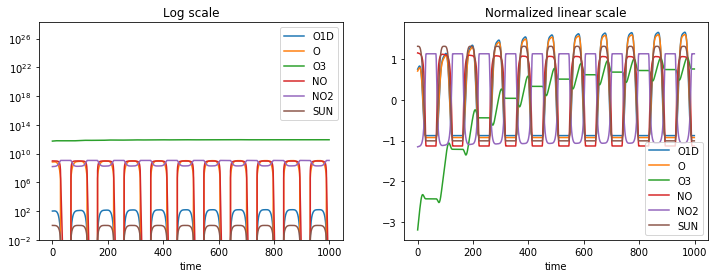

In [6]:
fig, axes = plt.subplots(1, 2, figsize=[12, 4])

df_history.plot(y=None, ylim=[1e-2, None], logy=True, ax=axes[0], title='Log scale')

df_history_scaled = df_history.copy() # don't modified the original data
StandardScaler(copy=False).fit_transform(df_history_scaled.values); # do in-place change to keep metadata
df_history_scaled.plot(ax=axes[1], title='Normalized linear scale')

In [7]:
df_range = df_history.agg(['min', 'max']).T
df_range.clip_lower(1e-8, inplace=True) # prevent small negative values
df_range

,min,max
O1D,1.000000e-08,1.550810e+02
O,1.000000e-08,1.040641e+09
O3,5.377002e+11,8.486620e+11
NO,1.000000e-08,9.433271e+08
NO2,1.531729e+08,1.096500e+09
SUN,1.000000e-08,1.000000e+00


## Random sampling from the above range to get y0

In [8]:
N_train = 5000 # number of training data

np.random.seed(42)
y0_list =  np.random.uniform(df_range['min'], df_range['max'],
                             size=(N_train, nvar+1))
y0_list.shape

(5000, 6)

Random sampling doesn't consider the correlation between species, which is unphysical! [O1D]/[O] should be almost constant. 

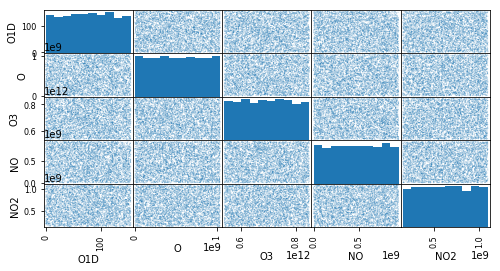

In [9]:
df_y0 = pd.DataFrame(y0_list[:,:-1], columns=varnames)
pd.plotting.scatter_matrix(df_y0, figsize=(8, 4), alpha=0.3, s=5);

In [10]:
%time y1_list = kpp.onestep(y0_list.T).T
y1_list.shape

CPU times: user 107 ms, sys: 1.28 ms, total: 109 ms
Wall time: 110 ms


(5000, 5)

## Integrate for one step (from y0 to y1) to get realistic correlation

Integrate the random samples for one step gives us meaningful correlation, especially O and O1D.

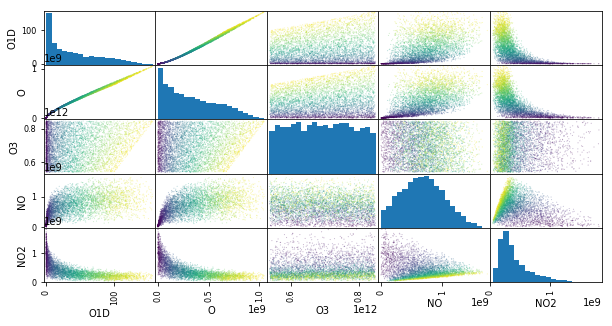

In [11]:
df_y1 = pd.DataFrame(y1_list, columns=varnames)
pd.plotting.scatter_matrix(df_y1, c=y0_list[:,-1], figsize=(10, 5), alpha=0.3, s=5, hist_kwds={'bins': 20});
# color is SUN intensity at the previous time step

## See if the distribution of y1 is representative enough

In [12]:
# Integrate for one more step to see if there's any significant change in species distribution

np.random.seed(41)
SUN_new = np.random.rand(N_train, 1) # use new sun intensity
%time y2_list = kpp.onestep(np.c_[y1_list, SUN_new].T).T  
y2_list.shape

CPU times: user 110 ms, sys: 1.11 ms, total: 111 ms
Wall time: 112 ms


(5000, 5)

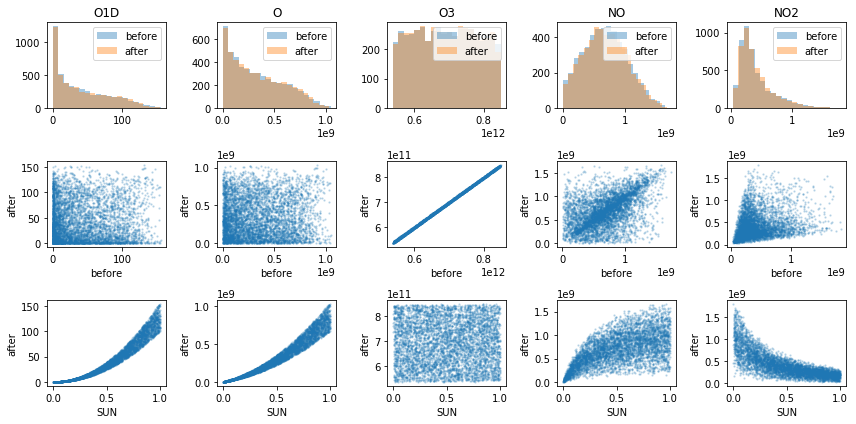

In [13]:
fig, axes = plt.subplots(3, 5, figsize=[12, 6])
for n in range(5):
    axes[0,n].hist(y1_list[:,n], bins=20, alpha=0.4, label='before')
    axes[0,n].hist(y2_list[:,n], bins=20, alpha=0.4, label='after')
    axes[0,n].legend()
    axes[0,n].set_title(varnames[n])
    
    axes[1,n].scatter(y1_list[:,n], y2_list[:,n], s=2, alpha=0.2)
    axes[1,n].set_xlabel('before')
    axes[1,n].set_ylabel('after')
    
    axes[2,n].scatter(SUN_new, y2_list[:,n], s=2, alpha=0.2)
    axes[2,n].set_xlabel('SUN')
    axes[2,n].set_ylabel('after')
    
fig.tight_layout()

# Individual data sample does change a lot from y1 to y2, but the overall distribution is not changed!
# Sun intensity plays an important role for radical species, but other species still have some impact.

# Preprocessing

Neural network requires input features to be normalized.

In [14]:
normalizer = StandardScaler()
normalizer.fit(y1_list[:,0:5]) # skip SUN, which is already in 0~1

StandardScaler(copy=True, with_mean=True, with_std=True)

In [15]:
X_train = np.c_[normalizer.transform(y1_list[:,0:5]), SUN_new]
X_train.shape

(5000, 6)

In [16]:
Y_train = normalizer.transform(y2_list) # use y1's scale
Y_train.std(axis=0) # highly normalized since y1 and y2 have similar distribution.

array([0.99371843, 0.99496781, 0.99433562, 0.99564591, 0.98363533])

# ANN training

In [17]:
# will make a copy from float64 to float32. 
# use torch.from_numpy() to share the same memory.
x_torch = torch.from_numpy(X_train)
y_torch = torch.from_numpy(Y_train)

In [18]:
def one_layer_net(H=12):
    model = torch.nn.Sequential(
        torch.nn.Linear(6, H),
        torch.nn.Tanh(),
        torch.nn.Linear(H, 5)
    )
    return model 
    
# weight initialization has no significant effect
# presumably because the net is quite small so it is easy to find minimum
torch.manual_seed(40) 
model = one_layer_net().double() # L-BFGS doesn't work at single precision. Not sure why.

In [19]:
%%time
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters())
for t in range(200):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%20==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.item())

20 0.00019839637192375193
40 8.593380203723223e-05
60 5.984038799537648e-05
80 3.7739390456394395e-05
100 2.5710206700417785e-05
120 2.2278647186245512e-05
140 1.7974015777040584e-05
160 1.578283531196357e-05
180 1.4546934822330704e-05
200 1.376507642707141e-05
CPU times: user 44.4 s, sys: 654 ms, total: 45 s
Wall time: 16 s


In [20]:
%%time 
y_pred = model(x_torch)
y_pred_numpy = y_pred.detach().numpy() # 40x faster than KPP

CPU times: user 1.82 ms, sys: 385 µs, total: 2.21 ms
Wall time: 1.66 ms


In [21]:
r2_score(y_pred_numpy, Y_train, multioutput='raw_values')

array([0.99998348, 0.99999034, 0.99999228, 0.99998011, 0.99998387])

## Scale-back to original concentration

In [22]:
y_pred_origin = normalizer.inverse_transform(y_pred_numpy)

In [23]:
def error_norm(y, y_true):
    """L1 error norm"""
    abserr = (np.abs(y - y_true)).mean(axis=0)
    return abserr/y_true.mean(axis=0)

In [24]:
error_norm(y_pred_origin, y2_list) # train error is only ~0.2%

array([0.00257071, 0.00178579, 0.00025549, 0.00158523, 0.00173549])

## Accuracy on test set

In [25]:
N_test = 10000

np.random.seed(39)
y0_test =  np.random.uniform(df_range['min'], df_range['max'],
                             size=(N_test, nvar+1))
%time y1_test = kpp.onestep(y0_test.T).T
y1_test.shape # this is the initial condition

CPU times: user 387 ms, sys: 13.4 ms, total: 400 ms
Wall time: 270 ms


(10000, 5)

In [26]:
np.random.seed(38)
SUN_test = np.random.rand(N_test, 1) # use new sun intensity
%time y2_test = kpp.onestep(np.c_[y1_test, SUN_test].T).T
y2_test.shape

CPU times: user 206 ms, sys: 3.84 ms, total: 210 ms
Wall time: 223 ms


(10000, 5)

In [27]:
X_test = np.c_[normalizer.transform(y1_test), SUN_test]
Y_test = normalizer.transform(y2_test) # true result for comparison
Y_test_pred = model(torch.from_numpy(X_test)).detach().numpy()

In [28]:
r2_score(Y_test_pred, Y_test, multioutput='raw_values')

array([0.99998402, 0.99999028, 0.99999221, 0.99998063, 0.99998377])

In [29]:
y2_test_pred = normalizer.inverse_transform(Y_test_pred)
y2_test_pred.shape

(10000, 5)

In [30]:
error_norm(y2_test_pred, y2_test) # test error is only ~0.1%

array([0.00254496, 0.00178141, 0.00025947, 0.0015619 , 0.00174753])

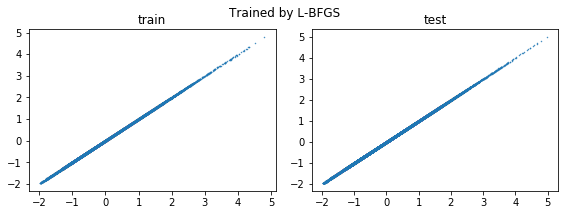

In [31]:
fig, axes = plt.subplots(1, 2, figsize=[8, 3])
axes[0].scatter(y_pred_numpy, Y_train, s=0.2)
axes[0].set_title('train')
axes[1].scatter(Y_test_pred, Y_test, s=0.2)
axes[1].set_title('test')
fig.suptitle('Trained by L-BFGS')
fig.tight_layout()

# Optimizer effect

## Full-batch gradient descent

In [32]:
torch.manual_seed(40) # use the same initial weight as L-BFGS case 
model_GD = one_layer_net().double()

In [33]:
%%time
def training_GD(model):
    """
    training data x_torch and y_torch are global variables
    Juse to avoid mess-up existing global variables (y_pred, optimizer, loss...)
    """
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    for t in range(8000): # takes roughly the same time as 200 steps of L-BFGS
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        optimizer.step()

        if (t+1)%1000==0:
            # no need to re-evaluate loss, unlike BFGS
            print(t+1, loss.item())

training_GD(model_GD)

1000 0.07098464515246512
2000 0.039299211636888286
3000 0.009306540288487673
4000 0.0030789196181917246
5000 0.001424998021909883
6000 0.0008745418660414519
7000 0.0006116504265842517
8000 0.00045461101897204903
CPU times: user 41.8 s, sys: 708 ms, total: 42.5 s
Wall time: 15.4 s


In [34]:
# training accuracy
Y_train_pred_GD = model_GD(x_torch).detach().numpy()
r2_score(Y_train_pred_GD, Y_train, multioutput='raw_values')

array([0.99952917, 0.99976166, 0.99978876, 0.99947703, 0.99912359])

In [35]:
error_norm(normalizer.inverse_transform(Y_train_pred_GD), y2_list) 

array([0.01471767, 0.00839085, 0.00136271, 0.00700943, 0.01259625])

In [36]:
# test accuracy
Y_test_pred_GD = model_GD(torch.from_numpy(X_test)).detach().numpy()
r2_score(Y_test_pred_GD, Y_test, multioutput='raw_values')

array([0.99952439, 0.99976705, 0.99980121, 0.99946058, 0.99906668])

In [37]:
error_norm(normalizer.inverse_transform(Y_test_pred_GD), y2_test) 

array([0.01497588, 0.00846153, 0.00135121, 0.00702531, 0.01270516])

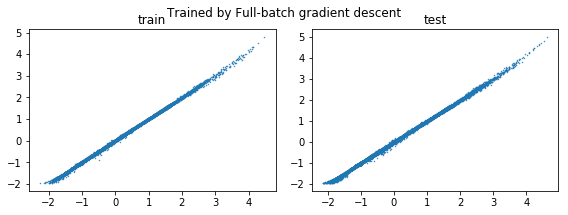

In [38]:
fig, axes = plt.subplots(1, 2, figsize=[8, 3])
axes[0].scatter(Y_train_pred_GD, Y_train, s=0.2)
axes[0].set_title('train')
axes[1].scatter(Y_test_pred_GD, Y_test, s=0.2)
axes[1].set_title('test')
fig.suptitle('Trained by Full-batch gradient descent')
fig.tight_layout()

## Mini-batch SGD

In [39]:
from torch.utils.data import DataLoader, TensorDataset # needed by SGD

In [40]:
torch.manual_seed(40) # use the same initial weight as L-BFGS case 
model_SGD = one_layer_net().double()

In [41]:
%%time
def training_SGD(model, batch_size=128, n_epoch=240, i_print=20):
    """Use global x_torch and y_torch"""
    dataloader = DataLoader(dataset=TensorDataset(x_torch, y_torch), batch_size=batch_size, shuffle=True)
    
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    for epoch in range(n_epoch):
        
        for step, (batch_x, batch_y) in enumerate(dataloader): 
            optimizer.zero_grad()
            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)
            loss.backward()
            optimizer.step()

        if (epoch+1)%i_print==0:
            print(epoch+1, loss.item()) # this is just the average loss on a mini-batch

torch.manual_seed(37) # deterministic shuffling
training_SGD(model_SGD)

20 0.042512207534566714
40 0.11683895589575126
60 0.02991090969141217
80 0.022438504394423874
100 0.006198172925778124
120 0.03697299624465232
140 0.0035512249192465096
160 0.000794904845531986
180 0.000888723535287242
200 0.0007091157490469722
220 0.0009407690058869407
240 0.0007871540299595522
CPU times: user 12.8 s, sys: 157 ms, total: 13 s
Wall time: 13.1 s


In [42]:
# training accuracy
Y_train_pred_SGD = model_SGD(x_torch).detach().numpy()
r2_score(Y_train_pred_SGD, Y_train, multioutput='raw_values')

array([0.99896702, 0.99966898, 0.99987891, 0.99848116, 0.99765422])

In [43]:
error_norm(normalizer.inverse_transform(Y_train_pred_SGD), y2_list) # ~2% error

array([0.02074113, 0.01009083, 0.00105992, 0.01374386, 0.02440169])

In [44]:
# test accuracy
Y_test_pred_SGD = model_SGD(torch.from_numpy(X_test)).detach().numpy()
r2_score(Y_test_pred_SGD, Y_test, multioutput='raw_values')

array([0.99895497, 0.99967248, 0.99988774, 0.99845399, 0.99747594])

In [45]:
error_norm(normalizer.inverse_transform(Y_test_pred_SGD), y2_test) 

array([0.02106986, 0.01026805, 0.0010324 , 0.01359861, 0.024552  ])

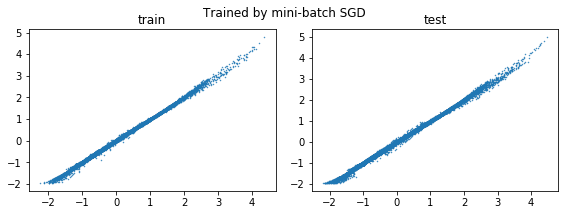

In [46]:
fig, axes = plt.subplots(1, 2, figsize=[8, 3])
axes[0].scatter(Y_train_pred_SGD, Y_train, s=0.2)
axes[0].set_title('train')
axes[1].scatter(Y_test_pred_SGD, Y_test, s=0.2)
axes[1].set_title('test')
fig.suptitle('Trained by mini-batch SGD')
fig.tight_layout()

# ANN prediction for multiple time steps

In [47]:
SUN_history = df_history['SUN']
SUN_history.shape

(1000,)

In [48]:
X0 = np.c_[normalizer.transform(y1_test), np.ones(10000)*SUN_history[0]]

In [49]:
def predict_multistep(y_init, Nt, model=model):
    '''
    y_init : [n_sample, nvar]
    Use global variable SUN_history as the forcing term'''    
    N_sample = y_init.shape[0] # N_sample*Nt should not be too large
    Y_history = np.empty([Nt, N_sample, nvar])
    
    X = np.c_[normalizer.transform(y_init), np.ones(N_sample)*SUN_history[0]]
    for t in range(Nt-1):
        Y = model(torch.from_numpy(X)).detach().numpy()
        Y_history[t] = Y # record normalized result. Need to scale back later
        
        X = np.c_[Y, np.ones(N_sample)*SUN_history[t]]

    return Y_history

In [50]:
n_sample = 1000
n_time = 40
%time y_pred_test_history = predict_multistep(y1_test[0:n_sample,:], n_time)
#normalizer.inverse_transform(y_pred_test_history, copy=False)
y_pred_test_history.shape

CPU times: user 25.8 ms, sys: 1.74 ms, total: 27.5 ms
Wall time: 14.2 ms


(40, 1000, 5)

In [51]:
%%time
y_test_history = np.empty_like(y_pred_test_history)
for i in range(n_sample):
    y_test_history[:,i,:] = kpp.forward(y1_test[i,:], n_time).T[:, :-1]
normalizer.transform(y_test_history.reshape(-1, nvar), copy=False);

CPU times: user 983 ms, sys: 5.23 ms, total: 988 ms
Wall time: 804 ms


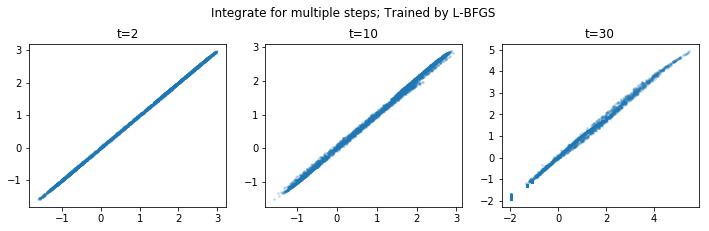

In [52]:
plt.figure(figsize=[12, 3])
for i, t in enumerate([2, 10, 30]):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_history[t], y_pred_test_history[t], s=3, alpha=0.2)
    plt.title(f't={t}')
    
plt.suptitle('Integrate for multiple steps; Trained by L-BFGS', y=1.05)

## Use SGD-trained model to predict multi-steps

In [53]:
y_SGD_history = predict_multistep(y1_test[0:n_sample,:], n_time, model=model_SGD)

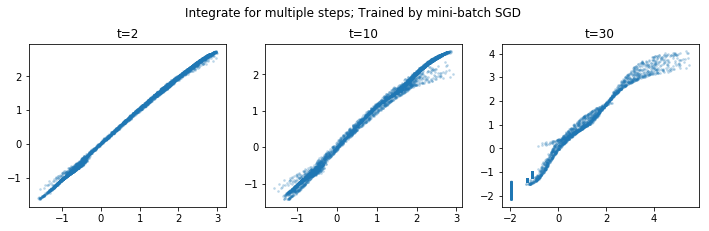

In [54]:
plt.figure(figsize=[12, 3])
for i, t in enumerate([2, 10, 30]):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_history[t], y_SGD_history[t], s=3, alpha=0.2)
    plt.title(f't={t}')
    
plt.suptitle('Integrate for multiple steps; Trained by mini-batch SGD', y=1.05)